# Deep & Cross Network (DCN)

In [1]:
import pprint

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_recommenders as tfrs

### Synthetic data generation

In [2]:
def get_mixer_data(data_size=100_000, random_seed=42):
    # We need to fix the random seed
    # to make colab runs repeatable.
    rng = np.random.RandomState(random_seed)
    country = rng.randint(200, size=[data_size, 1]) / 200.
    bananas = rng.randint(24, size=[data_size, 1]) / 24.
    cookbooks = rng.randint(6, size=[data_size, 1]) / 6.
    x = np.concatenate([country, bananas, cookbooks], axis=1)
    # # Create 1st-order terms.
    y = 0.1 * country + 0.4 * bananas + 0.7 * cookbooks
    # Create 2nd-order cross terms.
    y += 0.1 * country * bananas + 3.1 * bananas * cookbooks + (
          0.1 * cookbooks * cookbooks)
    return x, y

In [3]:
x, y = get_mixer_data()
num_train = 90000
train_x = x[:num_train]
train_y = y[:num_train]
eval_x = x[num_train:]
eval_y = y[num_train:]

### Model

In [4]:
class Model(tfrs.Model):

    def __init__(self, model):
        super().__init__()
        self._model = model
        self._logit_layer = tf.keras.layers.Dense(1)
        self.task = tfrs.tasks.Ranking(
          loss=tf.keras.losses.MeanSquaredError(),
          metrics=[
            tf.keras.metrics.RootMeanSquaredError("RMSE")
          ]
        )
        
    def call(self, x):
        x = self._model(x)
        return self._logit_layer(x)
    
    def compute_loss(self, features, training=False):
        x, labels = features
        scores = self(x)
        return self.task(
            labels=labels,
            predictions=scores,
        )

In [5]:
crossnet = Model(tfrs.layers.dcn.Cross())
deepnet = Model(
    tf.keras.Sequential([
      tf.keras.layers.Dense(512, activation="relu"),
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(128, activation="relu")
    ])
)

### Training

In [6]:
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(1000)
eval_data = tf.data.Dataset.from_tensor_slices((eval_x, eval_y)).batch(1000)

In [7]:
epochs = 100
learning_rate = 0.4

In [8]:
crossnet.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate))
crossnet.fit(train_data, epochs=epochs, verbose=False)

In [9]:
deepnet.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate))
deepnet.fit(train_data, epochs=epochs, verbose=False)

### Model evaluation

In [10]:
crossnet_result = crossnet.evaluate(eval_data, return_dict=True, verbose=False)
print(f"CrossNet(1 layer) RMSE is {crossnet_result['RMSE']:.4f} "
      f"using {crossnet.count_params()} parameters.")

deepnet_result = deepnet.evaluate(eval_data, return_dict=True, verbose=False)
print(f"DeepNet(large) RMSE is {deepnet_result['RMSE']:.4f} "
      f"using {deepnet.count_params()} parameters.")

CrossNet(1 layer) RMSE is 0.0072 using 16 parameters.
DeepNet(large) RMSE is 0.0220 using 166401 parameters.


### Model understanding

<ipython-input-11-8436e642fbfc>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels([''] + features, rotation=45, fontsize=10)
<ipython-input-11-8436e642fbfc>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels([''] + features, fontsize=10)


<Figure size 900x900 with 0 Axes>

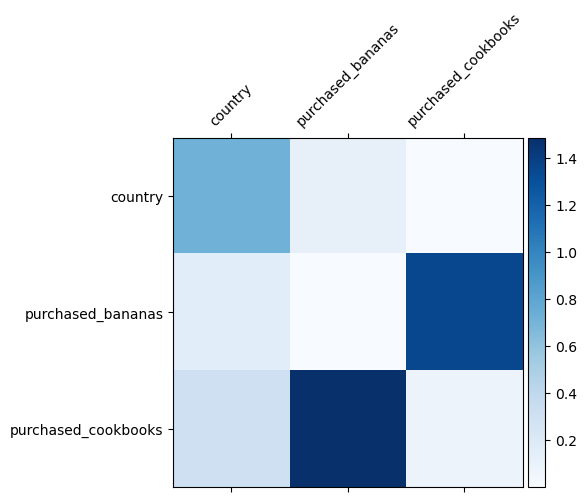

In [11]:
mat = crossnet._model._dense.kernel
features = ["country", "purchased_bananas", "purchased_cookbooks"]

plt.figure(figsize=(9,9))
im = plt.matshow(np.abs(mat.numpy()), cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([''] + features, rotation=45, fontsize=10)
_ = ax.set_yticklabels([''] + features, fontsize=10)

### Movielens 1M example

In [12]:
ratings = tfds.load("movie_lens/100k-ratings", split="train")
ratings = ratings.map(lambda x: {
    "movie_id": x["movie_id"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    "user_gender": int(x["user_gender"]),
    "user_zip_code": x["user_zip_code"],
    "user_occupation_text": x["user_occupation_text"],
    "bucketized_user_age": int(x["bucketized_user_age"]),
})

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\User\tensorflow_datasets\movie_lens\100k-ratings\0.1.1.incompleteWDOHWR\movie_lens-train.tf…

Dataset movie_lens downloaded and prepared to C:\Users\User\tensorflow_datasets\movie_lens\100k-ratings\0.1.1. Subsequent calls will reuse this data.


In [13]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

In [14]:
feature_names = ["movie_id", "user_id", "user_gender", "user_zip_code",
                 "user_occupation_text", "bucketized_user_age"]

vocabularies = {}

for feature_name in feature_names:
    vocab = ratings.batch(1_000_000).map(lambda x: x[feature_name])
    vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))

### Model construction

In [15]:
class DCN(tfrs.Model):

    def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
        super().__init__()
        self.embedding_dimension = 32
        str_features = ["movie_id", "user_id", "user_zip_code",
                        "user_occupation_text"]
        int_features = ["user_gender", "bucketized_user_age"]
        self._all_features = str_features + int_features
        self._embeddings = {}
        # Compute embeddings for string features.
        for feature_name in str_features:
            vocabulary = vocabularies[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential(
              [tf.keras.layers.StringLookup(
                  vocabulary=vocabulary, mask_token=None),
               tf.keras.layers.Embedding(len(vocabulary) + 1,
                                         self.embedding_dimension)
            ])
        # Compute embeddings for int features.
        for feature_name in int_features:
            vocabulary = vocabularies[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential(
              [tf.keras.layers.IntegerLookup(
                  vocabulary=vocabulary, mask_value=None),
               tf.keras.layers.Embedding(len(vocabulary) + 1,
                                         self.embedding_dimension)
            ])
        if use_cross_layer:
            self._cross_layer = tfrs.layers.dcn.Cross(
              projection_dim=projection_dim,
              kernel_initializer="glorot_uniform")
        else:
            self._cross_layer = None
        self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
          for layer_size in deep_layer_sizes]
        self._logit_layer = tf.keras.layers.Dense(1)
        self.task = tfrs.tasks.Ranking(
          loss=tf.keras.losses.MeanSquaredError(),
          metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
        )
        
    def call(self, features):
        # Concatenate embeddings
        embeddings = []
        for feature_name in self._all_features:
            embedding_fn = self._embeddings[feature_name]
            embeddings.append(embedding_fn(features[feature_name]))
        x = tf.concat(embeddings, axis=1)
        # Build Cross Network
        if self._cross_layer is not None:
            x = self._cross_layer(x)
        # Build Deep Network
        for deep_layer in self._deep_layers:
            x = deep_layer(x)
        return self._logit_layer(x)
    
    def compute_loss(self, features, training=False):
        labels = features.pop("user_rating")
        scores = self(features)
        return self.task(
            labels=labels,
            predictions=scores,
        )

### Training

In [16]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [17]:
def run_models(use_cross_layer, deep_layer_sizes, projection_dim=None, num_runs=5):
    models = []
    rmses = []
    for i in range(num_runs):
        model = DCN(use_cross_layer=use_cross_layer,
                    deep_layer_sizes=deep_layer_sizes,
                    projection_dim=projection_dim)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
        models.append(model)
        model.fit(cached_train, epochs=epochs, verbose=False)
        metrics = model.evaluate(cached_test, return_dict=True)
        rmses.append(metrics["RMSE"])
    mean, stdv = np.average(rmses), np.std(rmses)
    return {"model": models, "mean": mean, "stdv": stdv}

In [18]:
epochs = 8
learning_rate = 0.01

In [19]:
dcn_result = run_models(use_cross_layer=True,
                        deep_layer_sizes=[192, 192])

5/5 [==============================] - 0s 7ms/step - RMSE: 0.9318 - loss: 0.8685 - regularization_loss: 0.0000e+00 - total_loss: 0.8685


In [20]:
dcn_lr_result = run_models(use_cross_layer=True,
                           projection_dim=20,
                           deep_layer_sizes=[192, 192])

5/5 [==============================] - 9s 19ms/step - RMSE: 0.9308 - loss: 0.8671 - regularization_loss: 0.0000e+00 - total_loss: 0.8671


In [21]:
dnn_result = run_models(use_cross_layer=False,
                        deep_layer_sizes=[192, 192, 192])

5/5 [==============================] - 0s 6ms/step - RMSE: 0.9372 - loss: 0.8790 - regularization_loss: 0.0000e+00 - total_loss: 0.8790


In [22]:
print("DCN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_result["mean"], dcn_result["stdv"]))
print("DCN (low-rank) RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_lr_result["mean"], dcn_lr_result["stdv"]))
print("DNN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dnn_result["mean"], dnn_result["stdv"]))

DCN            RMSE mean: 0.9316, stdv: 0.0019
DCN (low-rank) RMSE mean: 0.9322, stdv: 0.0027
DNN            RMSE mean: 0.9406, stdv: 0.0057


### Model understanding

<ipython-input-23-ad3eb82fbd31>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
<ipython-input-23-ad3eb82fbd31>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels([""] + features, fontsize=10)


<Figure size 900x900 with 0 Axes>

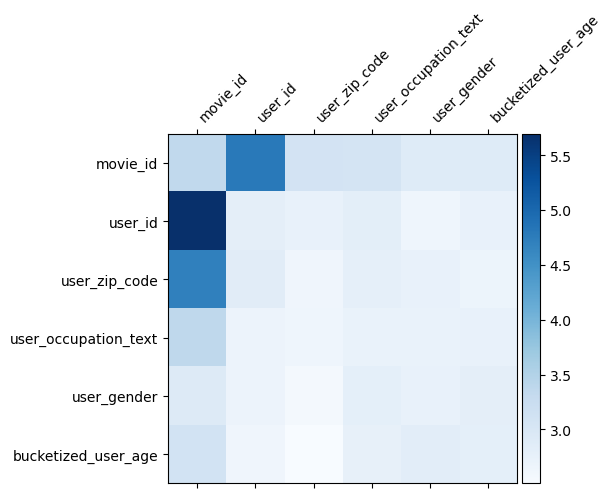

In [23]:
model = dcn_result["model"][0]
mat = model._cross_layer._dense.kernel
features = model._all_features

block_norm = np.ones([len(features), len(features)])

dim = model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
    for j in range(len(features)):
        block = mat[i * dim:(i + 1) * dim,
                    j * dim:(j + 1) * dim]
        block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(9,9))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)